<a href="https://colab.research.google.com/github/MahdiNouraie/CNN-Hoda-digit-farsi/blob/main/Hoda_digit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot

In [ ]:
import struct
import numpy as np
import cv2

def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result


def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image


def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels

In [ ]:
train_images, train_labels = read_hoda_cdb('/content/Train 60000.cdb')

In [ ]:
test_images, test_labels = read_hoda_cdb('/content/Test 20000.cdb')

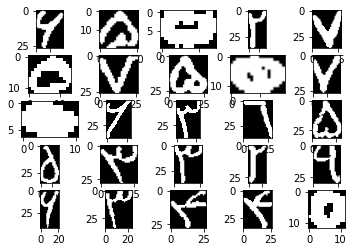

In [ ]:
for i in range(25):
	pyplot.subplot(5, 5, i+1)
	pyplot.imshow(train_images[i], cmap='gray')
pyplot.show()

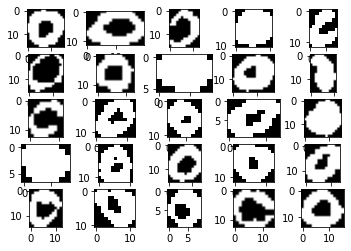

In [ ]:
for i in range(25):
	pyplot.subplot(5, 5, i+1)
	pyplot.imshow(test_images[i], cmap='gray')
pyplot.show()

In [ ]:
train = []
for i in range(len(train_images)):
  t = cv2.resize(train_images[i], dsize=(20, 20), interpolation=cv2.INTER_CUBIC)
  t = t / 255
  train.append(t)

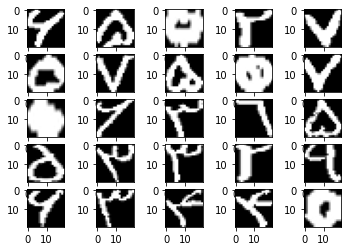

In [ ]:
for i in range(25):
	pyplot.subplot(5, 5, i+1)
	pyplot.imshow(train[i], cmap='gray')
pyplot.show()

In [ ]:
test = []
for i in range(len(test_images)):
  t = cv2.resize(test_images[i], dsize=(20, 20), interpolation=cv2.INTER_CUBIC)
  t = t / 255
  test.append(t)

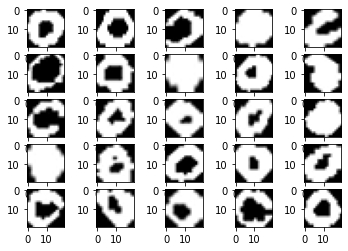

In [ ]:
for i in range(25):
	pyplot.subplot(5, 5, i+1)
	pyplot.imshow(test[i], cmap='gray')
pyplot.show()

In [ ]:
train = [np.expand_dims(train[i], axis = 0) for i in range(len(train))]
test = [np.expand_dims(test[i], axis = 0) for i in range(len(test))]

In [ ]:
tensor_x = torch.Tensor(train) 
tensor_y = torch.tensor(train_labels , dtype=torch.long)
train_dataset = TensorDataset(tensor_x,tensor_y) 

tensor_x2 = torch.Tensor(test) 
tensor_y2 = torch.tensor(test_labels, dtype=torch.long)
test_dataset = TensorDataset(tensor_x2,tensor_y2) 

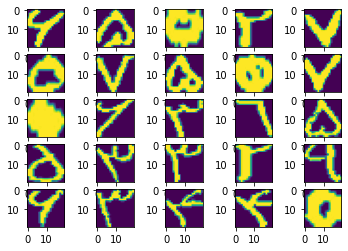

In [ ]:
for i in range(25):
	pyplot.subplot(5, 5, i+1)
	pyplot.imshow(train_dataset[i][0].squeeze(0))
pyplot.show()

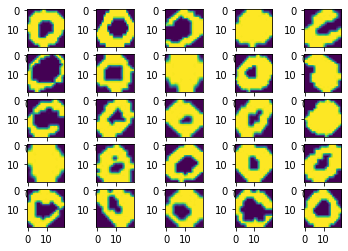

In [ ]:
for i in range(25):
	pyplot.subplot(5, 5, i+1)
	pyplot.imshow(test_dataset[i][0].squeeze(0))
pyplot.show()

In [ ]:
train = train_dataset
test = test_dataset
# prepare data loaders
train_dl = DataLoader(train, batch_size=64, shuffle=True)
val_dl = DataLoader(test, batch_size=1024, shuffle=False)

In [ ]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        images, labels = images.to(device) , labels.to(device)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        images, labels = images.to(device) , labels.to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class DigitClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256,10)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
num_epochs = 100
lr = 0.001
opt_func = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
model = DigitClassification()
model.to(device)
history = fit(num_epochs , lr , model , train_dl , val_dl)

Epoch [0], train_loss: 2.3030, val_loss: 2.3037, val_acc: 0.0977
Epoch [1], train_loss: 2.3029, val_loss: 2.3035, val_acc: 0.0977
Epoch [2], train_loss: 2.3028, val_loss: 2.3033, val_acc: 0.0977
Epoch [3], train_loss: 2.3027, val_loss: 2.3032, val_acc: 0.0977
Epoch [4], train_loss: 2.3026, val_loss: 2.3031, val_acc: 0.0977
Epoch [5], train_loss: 2.3026, val_loss: 2.3029, val_acc: 0.0977
Epoch [6], train_loss: 2.3025, val_loss: 2.3029, val_acc: 0.0977
Epoch [7], train_loss: 2.3025, val_loss: 2.3028, val_acc: 0.0977
Epoch [8], train_loss: 2.3024, val_loss: 2.3027, val_acc: 0.0977
Epoch [9], train_loss: 2.3024, val_loss: 2.3026, val_acc: 0.0977
Epoch [10], train_loss: 2.3024, val_loss: 2.3026, val_acc: 0.0977
Epoch [11], train_loss: 2.3023, val_loss: 2.3025, val_acc: 0.0977
Epoch [12], train_loss: 2.3023, val_loss: 2.3025, val_acc: 0.0977
Epoch [13], train_loss: 2.3023, val_loss: 2.3024, val_acc: 0.0977
Epoch [14], train_loss: 2.3022, val_loss: 2.3024, val_acc: 0.0977
Epoch [15], train_lo

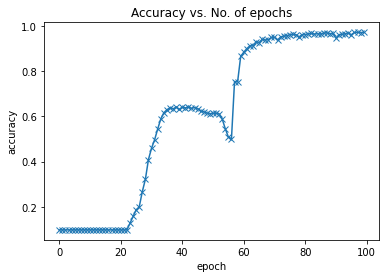

In [ ]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    pyplot.plot(accuracies, '-x')
    pyplot.xlabel('epoch')
    pyplot.ylabel('accuracy')
    pyplot.title('Accuracy vs. No. of epochs');
    
plot_accuracies(history)


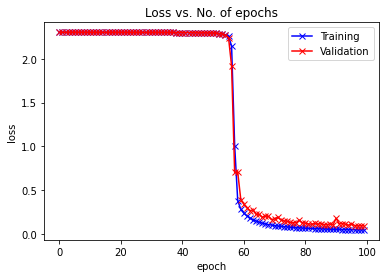

In [ ]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    pyplot.plot(train_losses, '-bx')
    pyplot.plot(val_losses, '-rx')
    pyplot.xlabel('epoch')
    pyplot.ylabel('loss')
    pyplot.legend(['Training', 'Validation'])
    pyplot.title('Loss vs. No. of epochs');

plot_losses(history)

In [ ]:
num_epochs = 100
lr = 0.001
opt_func = torch.optim.Adam
model = DigitClassification()
model.to(device)
history = fit(num_epochs , lr , model , train_dl , val_dl , opt_func= opt_func )

Epoch [0], train_loss: 0.1799, val_loss: 0.0968, val_acc: 0.9693
Epoch [1], train_loss: 0.0337, val_loss: 0.0533, val_acc: 0.9848
Epoch [2], train_loss: 0.0235, val_loss: 0.0394, val_acc: 0.9911
Epoch [3], train_loss: 0.0183, val_loss: 0.0427, val_acc: 0.9894
Epoch [4], train_loss: 0.0164, val_loss: 0.0292, val_acc: 0.9919
Epoch [5], train_loss: 0.0124, val_loss: 0.0641, val_acc: 0.9872
Epoch [6], train_loss: 0.0129, val_loss: 0.0386, val_acc: 0.9894
Epoch [7], train_loss: 0.0102, val_loss: 0.0320, val_acc: 0.9921
Epoch [8], train_loss: 0.0090, val_loss: 0.0468, val_acc: 0.9895
Epoch [9], train_loss: 0.0091, val_loss: 0.0780, val_acc: 0.9843
Epoch [10], train_loss: 0.0061, val_loss: 0.0303, val_acc: 0.9946
Epoch [11], train_loss: 0.0104, val_loss: 0.0449, val_acc: 0.9924
Epoch [12], train_loss: 0.0071, val_loss: 0.0415, val_acc: 0.9922
Epoch [13], train_loss: 0.0085, val_loss: 0.0408, val_acc: 0.9931
Epoch [14], train_loss: 0.0085, val_loss: 0.0293, val_acc: 0.9937
Epoch [15], train_lo

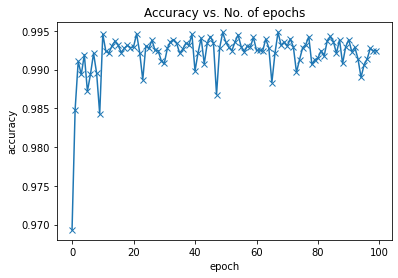

In [ ]:
plot_accuracies(history)

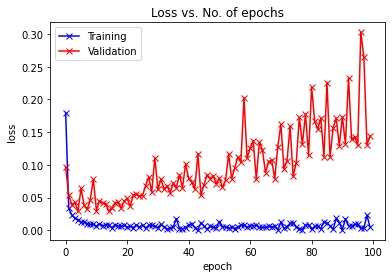

In [ ]:
plot_losses(history)

In [ ]:
num_epochs = 10
lr = 0.001
opt_func = torch.optim.Adam
model = DigitClassification()
model.to(device)
history = fit(num_epochs , lr , model , train_dl , val_dl , opt_func= opt_func )

Epoch [0], train_loss: 0.2003, val_loss: 0.1064, val_acc: 0.9706
Epoch [1], train_loss: 0.0308, val_loss: 0.0526, val_acc: 0.9852
Epoch [2], train_loss: 0.0238, val_loss: 0.0422, val_acc: 0.9898
Epoch [3], train_loss: 0.0202, val_loss: 0.0252, val_acc: 0.9935
Epoch [4], train_loss: 0.0128, val_loss: 0.0357, val_acc: 0.9905
Epoch [5], train_loss: 0.0138, val_loss: 0.0361, val_acc: 0.9921
Epoch [6], train_loss: 0.0142, val_loss: 0.0690, val_acc: 0.9840
Epoch [7], train_loss: 0.0109, val_loss: 0.0560, val_acc: 0.9873
Epoch [8], train_loss: 0.0073, val_loss: 0.0501, val_acc: 0.9924
Epoch [9], train_loss: 0.0098, val_loss: 0.0704, val_acc: 0.9894


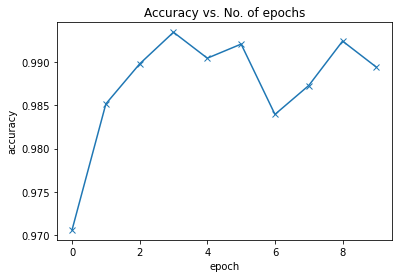

In [ ]:
plot_accuracies(history)

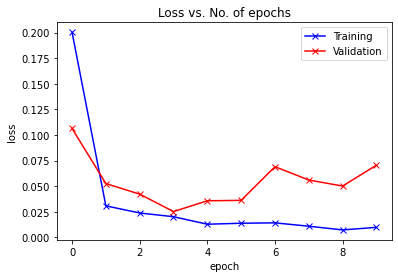

In [ ]:
plot_losses(history)

In [ ]:
new = test_dataset[2000][0]
new = np.expand_dims(new, axis = 0)
new = torch.Tensor(new)
new = new.to(device)
new.shape 

torch.Size([1, 1, 20, 20])

In [ ]:
torch.argmax(model(new))

tensor(1, device='cuda:0')

In [ ]:
test_dataset[2000][1]

tensor(1)

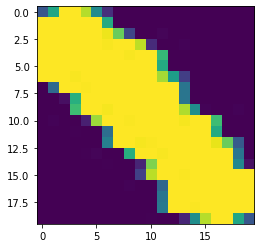

In [ ]:
pyplot.imshow(test_dataset[2000][0].squeeze(0))